   # Modelagem e Análise de Dados sobre um BD de alunos do PasseiDireto

   Olá! Esse Jupyter Notebook foi feito com o objetivo resolver o Desafio Prático do processo seletivo de "Estagiário de Dados" pelo PasseiDireto. Tentei resolver os problemas da forma mais otimizada e consistente possivel para atender tanto às solicitações do Desafio, quanto pensando no procedimento real de um Cientista de Dados ( C.D. ), na economia de memória e velocidade dos processos, e a partir disso montei um workflow em pequena escala de um pré-processamento de dados e modelagem de uma base BI, para facilitar as análises de um C.D. da PasseiDireto.
   

In [221]:
# Python 3.7.5 #

#### Tira o comentário se for necessário instalar esses ####
#!pip install folium 
#!pip install missingno
#!pip install plotly

# Biblioteca com as principais funções que fiz pro desafio do PasseiDireto
import passei_direto

# Bibliotecas para visualização dos dados
import missingno as msno # 0.4.2
import seaborn as sns # 0.9.0
import matplotlib # 3.1.0
import plotly # 4.1.1
import IPython # 7.6.1
import folium # 0.10.0
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline


# Bibliotecas para analisar e manipular os dados
import sklearn # 0.21.2
import scipy # 1.3.0
import numpy as np # 1.16.4
import pandas as pd # 0.24.2
from scipy import stats

# Bibliotecas que chamam funções adicionais
import json # 2.0.9
import os
import time
import random

# Bibliotecas de otimização
import numba # 0.44.1

## 0. Data Pipeline, arquitetura pensada sobre o framework Luigi

![](pd_edd_data_pipeline.png)


Na primeira parte do desafio, foi solicitada a modelagem de uma base analítica para BI com base no arquivo "BASE A" que me enviaram. Nessa mesma parte, recomendaram como opção a definição de um pipeline de dados, passei um tempo pensando sobre como organizar, limpar e recombinar os dados, e nesse processo cheguei a conclusão de que um procedimento simples, escalável de um pipeline de dados seria implementar o pacote Luigi para ordernar esses processos. 

A ideia foi feita sobre Luigi por que dele posso organizar os processos do data pipeline de grande escala, saber onde ocorrem os erros se os processos forem ordenados de forma consistente seguindo os princípios de orientação à objetos, e ele ajuda a coordenar processos sobre o Hadoop, AWS S3, SQL, rodar algoritmos de Machine Learning de forma paralela, sequencial, um dependendo de outros, enfim, são muitas possibilidades.

Por questões de tempo, não foi implementado o Luigi diretamente no Jupyter Notebook e nem no arquivo "passei_direto.py", mas a forma com que organizei os processos nesse Notebook, ilustraria a dependência dos processos e ordem de processamento.

## 1. Importação dos dados:

![](estrutura-dos-dados-antes.png)

In [222]:
df_courses = pd.read_json('datasets/courses.json', orient='records')
df_sessions = pd.read_json('datasets/sessions.json', orient='records')
df_sfs = pd.read_json('datasets/student_follow_subject.json', orient='records')
df_students = pd.read_json('datasets/students.json', orient='records')
df_subjects = pd.read_json('datasets/subjects.json', orient='records')
df_subscriptions = pd.read_json('datasets/subscriptions.json', orient='records')
df_universities = pd.read_json('datasets/universities.json', orient='records')

## 2. Refatorando os dados:

Olhando os dados, a princípio notei que talvez os dados de Id->Name seriam redundantes, alguns dados estavam com formatações de mais difícil manipulação, e pensando na legibilidade do banco BI, para alguém "bater" o olho e já tirar informações, facilitar a extração de informação, decidi proceder da seguinte forma:


##### 1. Vi que os dados de datas estavam no formato "YYYY-MM-DD HH:MM:SS.M", para manipular pensei que o ideal seria representá-los numa tupla, pois Strings consomem muito mais memória que tuplas, e pra ordenar numa série temporal me vi com mais facilidade de manipular tuplas, por experiência própria, mas é possível que hajam formatos de tempo que consomem menos memória que tuplas;

In [223]:
df_students.head()

,City,CourseId,Id,RegisteredDate,SignupSource,State,StudentClient,UniversityId
0,Rio de Janeiro,1199555,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,2012-09-06 17:27:11.370000,Facebook,Rio de Janeiro,NaN,664704
1,Rio de Janeiro,1199521,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,2012-09-05 15:31:08.090000,Facebook,Rio de Janeiro,NaN,664704
2,NaN,1199517,b8a39150d98d746853087a4107e9290976cb6c99d16a29...,2012-08-17 10:00:04.270000,Facebook,NaN,NaN,661625
3,Rio de Janeiro,1199491,0f6c90f966a70b84b70ea84a62d2e46ae4a2a237670815...,2012-10-22 21:16:52.157000,Facebook,Rio de Janeiro,NaN,664768
4,NaN,1199573,388bf84cffb3219384cd7a92153cf00f3b1416e4ff1473...,2012-10-24 01:48:53.700000,Facebook,Minas Gerais,NaN,663106


In [224]:
refactor = (df_students, df_sfs, df_subscriptions, df_sessions, df_subjects, df_courses, df_universities)
def time_tuple_conversion(refactor_data):
    # para análise de séries temporais, pode ser que ajude, não sei o padrão de uso
    for date in ("RegisteredDate", "PaymentDate", "FollowDate", "SessionStartTime"):
        try:
            for df in refactor_data:
                if date in df.columns:
                    df[date] = df[date].apply(lambda x: x[:19]).apply(time.strptime, args=["%Y-%m-%d %H:%M:%S"]).apply(lambda x: x[:6])
        except:
            print(f"Provavelmente já foi convertida a coluna {date}")
            pass

In [225]:
time_tuple_conversion(refactor)

In [226]:
df_students.head()

,City,CourseId,Id,RegisteredDate,SignupSource,State,StudentClient,UniversityId
0,Rio de Janeiro,1199555,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,"(2012, 9, 6, 17, 27, 11)",Facebook,Rio de Janeiro,NaN,664704
1,Rio de Janeiro,1199521,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,"(2012, 9, 5, 15, 31, 8)",Facebook,Rio de Janeiro,NaN,664704
2,NaN,1199517,b8a39150d98d746853087a4107e9290976cb6c99d16a29...,"(2012, 8, 17, 10, 0, 4)",Facebook,NaN,NaN,661625
3,Rio de Janeiro,1199491,0f6c90f966a70b84b70ea84a62d2e46ae4a2a237670815...,"(2012, 10, 22, 21, 16, 52)",Facebook,Rio de Janeiro,NaN,664768
4,NaN,1199573,388bf84cffb3219384cd7a92153cf00f3b1416e4ff1473...,"(2012, 10, 24, 1, 48, 53)",Facebook,Minas Gerais,NaN,663106


##### 2. Substituir em 'students.json' e 'student_follow_subject.json' os 'Id' pelos respectivos 'Name';

###### OBS.: Não alterei o StudentId, por que provavelmente ele pode entrar em conflito com outras bases do PasseiDireto por ser uma identificação única dos usuários, então alterar para um Id do tipo OrdinalCategory não faria sentido, por isso optei por manter a coerência do BD nesse sentido.

In [227]:
def create_id_to_name():
    for name in ("subjects","courses","universities"):
        LOC = f"""
global change_id_to_name_{name}
change_id_to_name_{name} = df_{name}.set_index('Id').to_dict()['Name']
"""
        exec(LOC)

In [228]:
create_id_to_name()

In [229]:
list(change_id_to_name_subjects.items())[:5]

[(682889, 'Eletrônica II'),
 (684377, 'Circuitos Elétricos II'),
 (698583, 'Eletrônica'),
 (757882, 'Circuitos II'),
 (1910475, 'Circuitos Elétricos e Eletrônicos 2')]

In [230]:
def replace_all_id_to_name():
    for name in ("subjects","courses","universities"):
        if name == "subjects":
            df_sfs.SubjectId.replace(change_id_to_name_subjects, inplace = True)
        elif name == "courses":
            df_students.CourseId.replace(change_id_to_name_courses, inplace = True)
        elif name == "universities":
            df_students.UniversityId.replace(change_id_to_name_universities,inplace = True)

In [231]:
replace_all_id_to_name()

In [232]:
df_students.head()

,City,CourseId,Id,RegisteredDate,SignupSource,State,StudentClient,UniversityId
0,Rio de Janeiro,Engenharia Elétrica,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,"(2012, 9, 6, 17, 27, 11)",Facebook,Rio de Janeiro,NaN,UERJ
1,Rio de Janeiro,Economia / Ciências Econômicas,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,"(2012, 9, 5, 15, 31, 8)",Facebook,Rio de Janeiro,NaN,UERJ
2,NaN,Direito,b8a39150d98d746853087a4107e9290976cb6c99d16a29...,"(2012, 8, 17, 10, 0, 4)",Facebook,NaN,NaN,PUC-RIO
3,Rio de Janeiro,Ciências Ambientais,0f6c90f966a70b84b70ea84a62d2e46ae4a2a237670815...,"(2012, 10, 22, 21, 16, 52)",Facebook,Rio de Janeiro,NaN,UNIRIO
4,NaN,Engenharia Química,388bf84cffb3219384cd7a92153cf00f3b1416e4ff1473...,"(2012, 10, 24, 1, 48, 53)",Facebook,Minas Gerais,NaN,UFSJ


##### 3. Enquanto pensava sobre os dados, notei que normalmente estava me referenciando sobre algumas colunas deles com mais frequência, e essa ordem de pensamento estava me ajudando a ter mais insights que na ordem "aleatória" que o DataFrame foi formatado, assim decidi organizar a coluna de cada DataFrame conforme a prioridade dela, de modo que ajudasse a quando olhar para o banco, já ter informações importantes próximas entre si.

In [233]:
df_sfs.head()

,FollowDate,StudentId,SubjectId
0,"(2015, 9, 7, 15, 49, 12)",0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Eletrônica II
1,"(2015, 9, 7, 15, 49, 12)",0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Circuitos Elétricos II
2,"(2015, 9, 7, 15, 49, 12)",0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Eletrônica
3,"(2015, 9, 7, 15, 49, 12)",0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Circuitos II
4,"(2015, 9, 7, 15, 49, 12)",0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Circuitos Elétricos e Eletrônicos 2


In [234]:
def organize_data():
    global df_students
    df_students = df_students[['Id', 'CourseId', 'UniversityId', 'State', 'City', 'RegisteredDate', 'StudentClient', 'SignupSource']]
    global df_sfs
    df_sfs = df_sfs[['StudentId', 'SubjectId', 'FollowDate']]
    global df_subscriptions
    df_subscriptions = df_subscriptions[['StudentId', 'PlanType', 'PaymentDate']]
    global df_sessions
    df_sessions = df_sessions[['StudentId', 'SessionStartTime', 'StudentClient']]

In [235]:
organize_data()

In [236]:
df_sfs.head()

,StudentId,SubjectId,FollowDate
0,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Eletrônica II,"(2015, 9, 7, 15, 49, 12)"
1,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Circuitos Elétricos II,"(2015, 9, 7, 15, 49, 12)"
2,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Eletrônica,"(2015, 9, 7, 15, 49, 12)"
3,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Circuitos II,"(2015, 9, 7, 15, 49, 12)"
4,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Circuitos Elétricos e Eletrônicos 2,"(2015, 9, 7, 15, 49, 12)"


## 3. Limpando os dados:

Iniciando a análise sobre os dados notei que faltava quase **2/3** dos registros de cidades e estados dos usuários, e para modelos de predição de uso, consumo da plataforma, são informações que normalmente devem ser muito importantes junto da universidade e do curso do usuário, para aumentar a precisão dos modelos.

In [237]:
df_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 8 columns):
Id                60000 non-null object
CourseId          60000 non-null object
UniversityId      60000 non-null object
State             24607 non-null object
City              19753 non-null object
RegisteredDate    60000 non-null object
StudentClient     51541 non-null object
SignupSource      60000 non-null object
dtypes: object(8)
memory usage: 3.7+ MB


Para visualizar melhor, usei o módulo MissingNo, que ajuda a visualizar dados faltantes no banco de dados, onde fica marcado em cinza escuro se existe dado e branco de não.

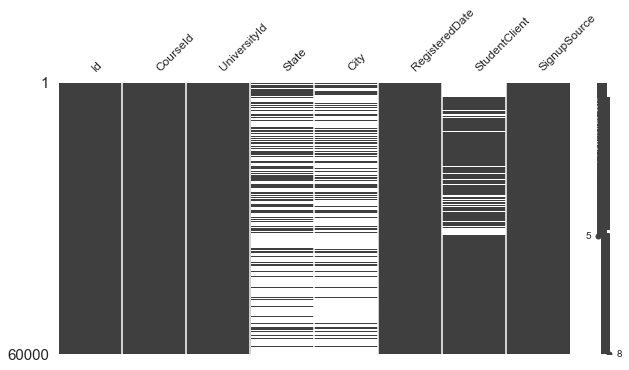

In [238]:
display(msno.matrix(df_students, figsize=(10, 5), width_ratios=(20,1), fontsize=12))

O que nos diz muito sobre a necessidade de imputar dados sobre o banco, que foi o meu próximo procedimento.

### 3.1 Imputação de dados faltantes:

Para imputar os dados faltantes do Banco de Dados passei um tempo pensando e notei uma estrutura entre as colunas 'UniversityId', 'State' e 'City'; cada uma tem uma "informação" sobre a outra implicitamente, pois todas as três são correlacionadas pela localização do aluno, e disso tirei uma solução para conseguir imputar os dados sem o viés geográfico e econômico que teria uma imputação com 'kNN', 'Generalized Low Rank Model', etc, me baseando na distribuição probabilística de cada um sobre o outro.

Existe um algoritmo famoso para Redes Bayesianas chamado 'Belief Propagation', que tem a seguinte ideia, tendo um grafo de informações, cada nó tem uma aresta com outro nós se seus eventos estiverem relacionados. Cada um desses nós tem uma probabilidade ou importância associada ( dita *Potential Function* ou fator ), resumidamente, eu posso iterar um processo sobre os fatores desses nós, de modo que eles "troquem" informações entre si até convergir no estado mais provável desses nós de "estado".

A ideia que implementei seria parecida, pensei que por exemplo, na coluna de estados, se eu pegasse o Rio de Janeiro, as cidades associadas ao Rio de Janeiro fazem parte do Rio de Janeiro provavelmente, pelo o que vi no banco não tinham inconsistências sobre isso, então peguei a distribuição das cidades mais frequentes dos usuários do Rio de Janeiro, e imputei em relação a distribuição das cidades sobre o estado do Rio do Janeiro que constavam 'NaN', iterando por todos os estados preenchi muitas cidades com boa precisão estatística, e sem conflitos do tipo botar no estado do Rio de Janeiro a cidade de Florianópolis, coisa que outros algoritmos provavelmente fariam.

O mesmo fiz no inverso, de Cidades para Estados, e depois de Universidades para Estados, e depois de volta em Estados para Cidades, seguindo o algoritmo abaixo que implementei sob a classe 'TransferInformation'.

In [239]:
class TransferInformation:

    def __init__(self,df_students):
        self.df_students = df_students

    def from_cities_to_states(self):
        print("Tranferindo informações de 'City' para 'State'...")
        dict_city_state = {}
        lista_imp_city = []
        cidades = tuple(
            self.df_students["City"].value_counts().reset_index()["index"].values)

        for cidade in cidades:
            df_imp = pd.DataFrame(
                self.df_students[["State", "City"]].loc[self.df_students['City'] == cidade])
            norm_val = df_imp["State"].value_counts().reset_index()[
                "State"].sum()
            lista_val = pd.DataFrame(self.df_students[["State", "City"]].loc[self.df_students['City'] == cidade]["State"].value_counts(
            )).reset_index()["State"].apply(lambda x: round(x / norm_val, 4))
            dict_city_state[cidade] = tuple(
                zip(df_imp["State"].value_counts().reset_index()["index"], lista_val))

        for cidade in cidades:
            city_nans = self.df_students[[
                "State", "City"]].loc[self.df_students['City'] == cidade].loc[self.df_students['State'].isna()]
            population_city = list(pd.DataFrame(
                list(dict_city_state[cidade]))[0])
            distribution = list(pd.DataFrame(list(dict_city_state[cidade]))[1])
            if len(distribution) == 1:
                city_nans["State"] = population_city[0]
            else:
                city_nans["State"] = city_nans["State"].apply(lambda x: random.choices(
                    population=population_city, weights=distribution, k=1))
            lista_imp_city.append(city_nans)

        imp_city = pd.concat(lista_imp_city)
        imp_city["State"] = imp_city["State"].apply(
            lambda x: str(x).strip("[").strip("]").strip("'"))

        idx = imp_city.index.intersection(self.df_students.index)
        cols = imp_city.columns.intersection(self.df_students.columns)

        self.df_students = imp_city.loc[idx, cols].combine_first(self.df_students)
        print("Terminado.\n")

    def from_states_to_cities(self):
        print("Tranferindo informações de 'State' para 'City'...")
        dict_state_city = {}
        lista_imp_states = []

        estados = tuple(
            self.df_students["State"].value_counts().reset_index()["index"].values)

        for estado in estados:
            df_imp = pd.DataFrame(
                self.df_students[["State", "City"]].loc[self.df_students['State'] == estado])
            norm_val = df_imp["City"].value_counts().reset_index()[
                "City"].sum()
            lista_val = pd.DataFrame(self.df_students[["State", "City"]].loc[self.df_students['State'] == estado]["City"].value_counts(
            )).reset_index()["City"].apply(lambda x: round(x / norm_val, 4))
            dict_state_city[estado] = tuple(
                zip(df_imp["City"].value_counts().reset_index()["index"], lista_val))

        for estado in estados:
            state_nans = self.df_students[[
                "State", "City"]].loc[self.df_students['State'] == estado].loc[self.df_students['City'].isna()]
            population_state = list(pd.DataFrame(
                list(dict_state_city[estado]))[0])
            distribution = list(pd.DataFrame(list(dict_state_city[estado]))[1])

            state_nans["City"] = state_nans["City"].apply(lambda x: random.choices(
                population=population_state, weights=distribution, k=1))
            lista_imp_states.append(state_nans)

        imp_states = pd.concat(lista_imp_states)
        imp_states["City"] = imp_states["City"].apply(
            lambda x: str(x).strip("[").strip("]").strip("'"))

        idx = imp_states.index.intersection(self.df_students.index)
        cols = imp_states.columns.intersection(self.df_students.columns)

        self.df_students = imp_states.loc[idx,
                                          cols].combine_first(self.df_students)
        print("Terminado.\n")

    def from_universities_to_states(self):
        print("Tranferindo informações de 'UniversityId' para 'City'...")
        dict_univ_state = {}
        lista_imp_univ_state = []

        universidades = tuple(
            self.df_students["UniversityId"].value_counts().reset_index()["index"].values)[
            :250]

        for univ in universidades:
            df_imp = pd.DataFrame(self.df_students[[
                                  "UniversityId", "State"]].loc[self.df_students['UniversityId'] == univ])
            norm_val = df_imp["State"].value_counts().reset_index()[
                "State"].sum()

            lista_val = pd.DataFrame(self.df_students[["State", "UniversityId"]].loc[self.df_students['UniversityId'] == univ]["State"].value_counts(
            )).reset_index()["State"].apply(lambda x: round(x / norm_val, 4))
            dict_univ_state[univ] = tuple(
                zip(df_imp["State"].value_counts().reset_index()["index"], lista_val))

        for univ in universidades:
            try:
                univ_nans = self.df_students[[
                    "State", "UniversityId"]].loc[self.df_students['UniversityId'] == univ].loc[self.df_students['State'].isna()]
                population_univ = list(pd.DataFrame(
                    list(dict_univ_state[univ]))[0])
                distribution = list(pd.DataFrame(
                    list(dict_univ_state[univ]))[1])
                if len(distribution) == 1:
                    univ_nans["State"] = population_univ[0]
                else:
                    univ_nans["State"] = univ_nans["State"].apply(lambda x: random.choices(
                        population=population_univ, weights=distribution, k=1))
                lista_imp_univ_state.append(univ_nans)
            except BaseException:
                pass

        imp_univ = pd.concat(lista_imp_univ_state)
        imp_univ["State"] = imp_univ["State"].apply(
            lambda x: str(x).strip("[").strip("]").strip("'"))

        idx = imp_univ.index.intersection(self.df_students.index)
        cols = imp_univ.columns.intersection(self.df_students.columns)

        self.df_students = imp_univ.loc[idx,
                                        cols].combine_first(self.df_students)
        print("Terminado.\n")

    def imputar_dados(self,full_cycle=1):
        self.df_students = df_students
        for i in range(full_cycle):
            self.from_states_to_cities()
            self.from_cities_to_states()
            self.from_universities_to_states()
            self.from_states_to_cities()
        return self.df_students



In [240]:
ti = TransferInformation(df_students)

In [241]:
df_students = ti.imputar_dados()

Tranferindo informações de 'State' para 'City'...
Terminado.

Tranferindo informações de 'City' para 'State'...
Terminado.

Tranferindo informações de 'UniversityId' para 'City'...
Terminado.

Tranferindo informações de 'State' para 'City'...
Terminado.



In [242]:
df_students.head()

,City,CourseId,Id,RegisteredDate,SignupSource,State,StudentClient,UniversityId
0,Rio de Janeiro,Engenharia Elétrica,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,"(2012, 9, 6, 17, 27, 11)",Facebook,Rio de Janeiro,NaN,UERJ
1,Rio de Janeiro,Economia / Ciências Econômicas,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,"(2012, 9, 5, 15, 31, 8)",Facebook,Rio de Janeiro,NaN,UERJ
2,Bayeux,Direito,b8a39150d98d746853087a4107e9290976cb6c99d16a29...,"(2012, 8, 17, 10, 0, 4)",Facebook,Paraíba,NaN,PUC-RIO
3,Rio de Janeiro,Ciências Ambientais,0f6c90f966a70b84b70ea84a62d2e46ae4a2a237670815...,"(2012, 10, 22, 21, 16, 52)",Facebook,Rio de Janeiro,NaN,UNIRIO
4,Três Pontas,Engenharia Química,388bf84cffb3219384cd7a92153cf00f3b1416e4ff1473...,"(2012, 10, 24, 1, 48, 53)",Facebook,Minas Gerais,NaN,UFSJ


Olhando rapidamente o 'head' das o banco parece consistente a distriubuição de cidades-estados-universidades, vamos visualizar para ver como ficou no final:

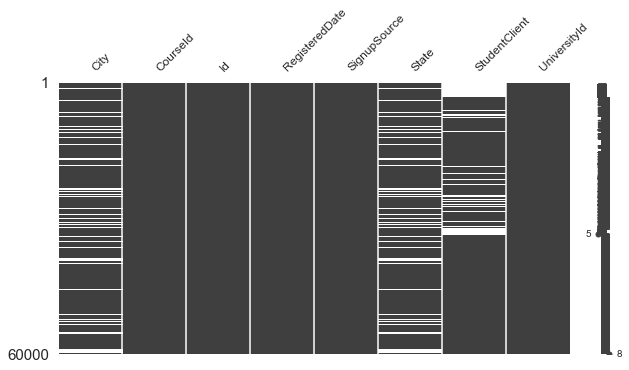

In [243]:
display(msno.matrix(df_students, figsize=(10, 5), width_ratios=(20,1), fontsize=12))

### 3.2 Correção de tipos ( Categorical Data Types ):


Até o momento notei que manipulei muitos dados redundantes, mas relevantes pela forma que estavam organizados, pensando nisso decidi converter os dados iniciais categóricos em CategoricalDataTypes do módulo pandas, e tive uma boa redução de gasto de memória com isso.

In [270]:
antes_mem = df_students.memory_usage().sum()

In [271]:
def convert_to_category():
    #converter todas as colunas categoricas para category data type pra economizar memória
    for column in df_students.columns:
        df_students[column] = df_students[column].astype('category')

In [272]:
convert_to_category()

In [273]:
depois_mem = df_students.memory_usage().sum()

In [276]:
df_dict = pd.DataFrame([[antes_mem/1000000,depois_mem/1000000]], columns=['Memória consumida depois, em MB', 'Memória consumida antes, em MB'])

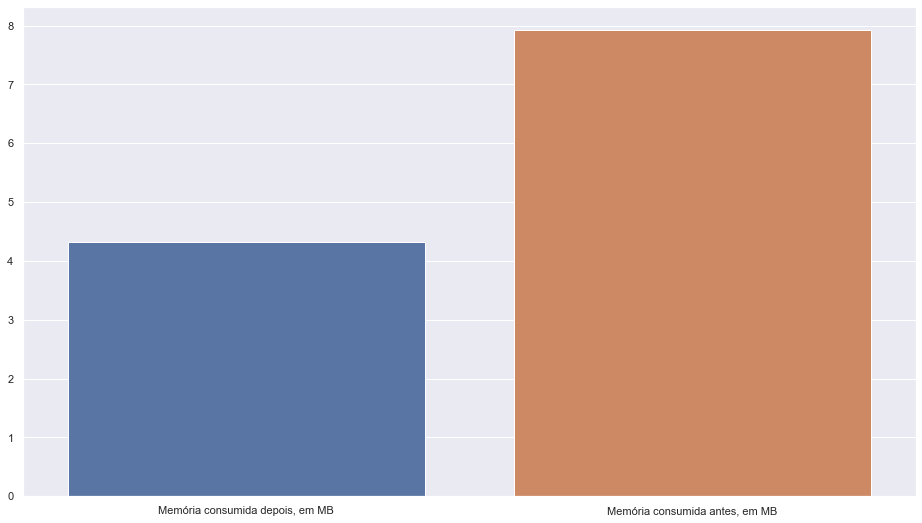

In [277]:
sns.barplot(data=df_dict)

mostra agora o consumo de memória por esses bancos de dados

## 4. Fazendo novos bancos consolidados para BI
![](new_df.png)

Pensando e repensando sobre os dados, pensei em cinco bases resultantes que poderiam auxiliar na produtividade de um Cientista de Dados, para ver as informações do banco de uma forma que fosse mais intuitiva analisar sobre, colocando informações na mesma tabela de forma que facilitasse a aplicação de um algoritmo de predição ou classificação, usando talvez um One-Hot Encoding, ou [embedding methods](https://www.fast.ai/2018/04/29/categorical-embeddings/) para aplicar algoritmos de Deep Learning sobre a base. 

Não fiz isso pois o objetivo central dessas novas bases não era já formatar de modo que facilitasse esses procedimentos, mas sim facilitar a legibilidade e interpretabilidade dos dados.

In [244]:
def create_new_bases():
    
    global students_subjects
    global students_subjects_subscriptions
    global students_sessions
    global sessions_subscriptions
    global students_subscriptions
    
    students_subjects = df_sfs.rename(columns = {"StudentId":"Id"}).merge(df_students, on= ["Id"]).rename(
        columns = {"Id":"StudentId", "SubjectId":"SubjectName", "CourseId": "CourseName",
                    "UniversityId":"UniversityName" })[
    ['StudentId', 'CourseName', 'UniversityName', 'RegisteredDate', 'State', 'City', 'SubjectName', 'FollowDate', 'StudentClient', 'SignupSource']];

    students_subjects_subscriptions = df_sfs.rename(columns = {"StudentId":"Id"}).merge(df_students, on= ["Id"]).rename(
        columns = {"Id":"StudentId", "SubjectId":"SubjectName", "CourseId": "CourseName",
                    "UniversityId":"UniversityName" })[
    ['StudentId', 'CourseName', 'UniversityName', 'RegisteredDate', 'State', 'City', 'SubjectName', 'FollowDate', 'StudentClient', 'SignupSource']].merge(df_subscriptions, on = ["StudentId"]);

    students_sessions = df_sessions.rename(columns = {"StudentId":"Id"}).merge(df_students, on = ["Id"]).rename(
        columns = {"Id":"StudentId","CourseId":"CourseName","UniversityId":"UniversityName"})[['StudentId','CourseName','UniversityName','SessionStartTime','StudentClient_x','StudentClient_y','State','City','RegisteredDate','SignupSource']];

    sessions_subscriptions = df_sessions.merge(df_subscriptions, on= ["StudentId"])[['StudentId','SessionStartTime','StudentClient','PaymentDate', 'PlanType']];

    students_subscriptions = df_subscriptions.rename(columns = {"StudentId":"Id"}).merge(df_students, on= ["Id"]).rename(
        columns = {"Id":"StudentId", "CourseId": "CourseName",
                    "UniversityId":"UniversityName" })[['StudentId', 'UniversityName', 'CourseName', 'PlanType', 'PaymentDate', 'State', 'City', 'RegisteredDate', 'SignupSource', 'StudentClient']];


In [245]:
create_new_bases()

In [279]:
sessions_subscriptions.head()

,StudentId,SessionStartTime,StudentClient,PaymentDate,PlanType
0,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,"(2017, 11, 12, 5, 18, 26)",Website,"(2017, 11, 14, 19, 52, 36)",Mensal
1,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,"(2017, 11, 12, 6, 50, 25)",Website,"(2017, 11, 14, 19, 52, 36)",Mensal
2,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,"(2017, 11, 12, 7, 10, 22)",Website,"(2017, 11, 14, 19, 52, 36)",Mensal
3,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,"(2017, 11, 12, 13, 29, 23)",Website,"(2017, 11, 14, 19, 52, 36)",Mensal
4,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,"(2017, 11, 14, 4, 49, 46)",Website,"(2017, 11, 14, 19, 52, 36)",Mensal


In [280]:
students_subscriptions.head()

,StudentId,UniversityName,CourseName,PlanType,PaymentDate,State,City,RegisteredDate,SignupSource,StudentClient
0,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,ESTÁCIO EAD,Administração,Mensal,"(2017, 11, 14, 19, 52, 36)",Minas Gerais,Belo Horizonte,"(2012, 10, 30, 17, 2, 8)",Email,NaN
1,b2bace77d15c3dfaf57bf9916f0e9924d12f89bdc0624c...,CEFET/MG,Engenharia Elétrica,Mensal,"(2017, 11, 8, 11, 52, 9)",Minas Gerais,Coronel Fabriciano,"(2012, 12, 3, 19, 54, 48)",Facebook,NaN
2,f423d6fe2f8964db634c7806e03b0f6567e992e994f06f...,ESTÁCIO,Direito,Mensal,"(2017, 11, 5, 21, 27, 47)",Espírito Santo,Serra,"(2013, 4, 3, 12, 37, 45)",Email,NaN
3,55ccbe518d2edbbd527eddca1431c7f7f3a4676bdbee38...,ESTÁCIO,Direito,Mensal,"(2017, 11, 15, 14, 36, 42)",Rio de Janeiro,Rio de Janeiro,"(2013, 4, 3, 16, 0, 6)",Email,NaN
4,b1b0f63fe3e4820cb082531af7c8911cd380e5ec8fe822...,ESTÁCIO,Direito,Mensal,"(2017, 11, 12, 22, 19, 54)",Rio de Janeiro,Saquarema,"(2013, 4, 3, 16, 9, 36)",Facebook,NaN


In [281]:
students_subjects_subscriptions.head()

,StudentId,CourseName,UniversityName,RegisteredDate,State,City,SubjectName,FollowDate,StudentClient,SignupSource,PlanType,PaymentDate
0,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Belo Horizonte,Administração de Recursos Humanos,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"
1,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Belo Horizonte,Gestão da Cadeia de Suprimentos,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"
2,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Belo Horizonte,Gestão Financeira de Pequenas e Médias Empresas,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"
3,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Belo Horizonte,Constituição e Legalização de Pequenas e Média...,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"
4,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Belo Horizonte,Administração de Novos Negócios Av1 A Av5,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"


Pensando no pipeline dos dados, montei uma função que automaticamente exportaria os novos dados para uma pasta do mês delas, e ideia é que o scheduler do Luigi faria automaticamente a atualização do banco consolidado de dados, adicionando toda semana os novos dados acumulados para o Cientista de Dados fazer suas análise sobre elas.

In [247]:
def export_new_database():

    time_string = time.asctime().replace(" ", "_")
    time_string = time_string[20:24] +"_"+ time_string[4:7] +"_"+ time_string[8:10]
    new_path = f"banco_bi/database/{time_string}"
    ssj = f"{new_path}/students_subjects_{time_string}.csv"
    ssjsub = f"{new_path}/students_subjects_subscriptions_{time_string}.csv"
    sse = f"{new_path}/students_sessions_{time_string}.csv"
    sesub =  f"{new_path}/sessions_subscriptions_{time_string}.csv"
    ssub = f"{new_path}/students_subscriptions_{time_string}.csv"

    try:
        os.makedirs(new_path)

        students_subjects.to_csv(ssj)
        students_subjects_subscriptions.to_csv(ssjsub)
        students_sessions.to_csv(sse)
        sessions_subscriptions.to_csv(sesub)
        students_subscriptions.to_csv(ssub)

    except FileExistsError:

        students_subjects.to_csv(ssj)
        students_subjects_subscriptions.to_csv(ssjsub)
        students_sessions.to_csv(sse)
        sessions_subscriptions.to_csv(sesub)
        students_subscriptions.to_csv(ssub)


In [248]:
export_new_database()

## 5. Visualizando e interpretando os dados

Para a segunda parte do Desafio, decidi focar em visualizar as possíveis análises que poderia fazer sobre os dados do banco original e os que montei, para mostrar a versatilidade que esse pequeno banco de dados pode nos dar de informações sobre o negócio, e como pode ajudar em decisões gerenciais.

### 1ª Pergunta - Quais são os 5 maiores cursos do Passei Direto?

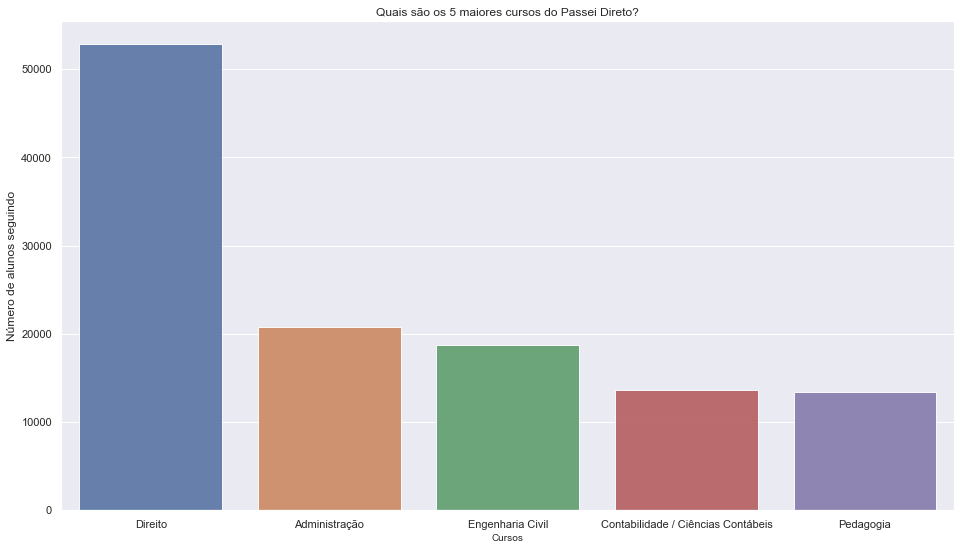

In [283]:
sns.set(style="darkgrid",rc={'figure.figsize':(16,9)})
sns.barplot(students_subjects.CourseName.value_counts().head(5).index, students_subjects.CourseName.value_counts().head(5).values, alpha=0.9)
plt.title('Quais são os 5 maiores cursos do Passei Direto?')
plt.ylabel('Número de alunos seguindo', fontsize=12)
plt.xlabel('Cursos', fontsize=10)
plt.show()

### 2. Quais são as 3 universidades com mais acessos dos usuários Premium?

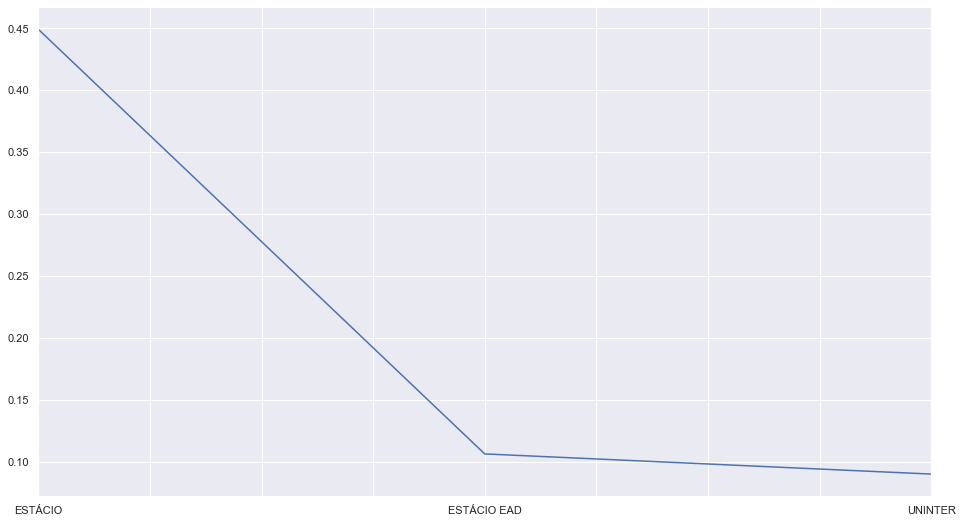

In [291]:
plan_session = df_subscriptions.set_index("StudentId").join(df_sessions.groupby("StudentId").count())[["PlanType","SessionStartTime"]]
plan_session.merge(df_students.rename(columns = {"Id":"StudentId"}), on = ["StudentId"]).UniversityId.value_counts(normalize=True).head(3).plot()

Algumas outras interpretações rápidas que podemos tirar dos dados seriam:

1. Dos estudantes quais as principais fontes de inscrição no sites?

In [306]:
df_students.SignupSource.value_counts()

Facebook    30346
Google      19312
Email       10342
Name: SignupSource, dtype: int64

2. Os estudantes usam normalmente qual interface para entrar no PasseiDireto?

In [250]:
df_students.StudentClient.value_counts().head(7)

Website                     38415
Webapp                       3214
Android | 6.0.1 | sdk 23     2137
Android | 7.0 | sdk 24       1059
Android | 6.0 | sdk 23       1045
Android | 5.1.1 | sdk 22      646
Android | 4.4.4 | sdk 19      434
Name: StudentClient, dtype: int64

3. Quais as universidades que mais têm alunos registrados no site? ( Pode ajudar a indicar parcerias, ou fazendo uma análise de séries temporais ver quais parcerias podem ser as melhores a antecipar )

In [251]:
df_students.UniversityId.value_counts().head(5)

ESTÁCIO        9030
UNIP           4426
UNOPAR         1857
UNINTER        1856
ESTÁCIO EAD    1478
Name: UniversityId, dtype: int64

4. Analisar quais os assuntos mais consumidos pode nos dar uma ideia de qual material didático investir mais, ver qual teve a tendência a ser mais consumido mas foi menos pode indicar se esse material precisa de mais atenção em relação aos materiais didáticos que o PasseiDireto fornece, ou a qualidade dos foruns desses materiais

In [259]:
students_subjects.SubjectName.value_counts().head(15)

Bioquímica                          4223
Cálculo I                           4053
Anatomia Humana                     3950
Direito Constitucional              3926
Matemática Financeira               3405
Física I                            3023
Direito Penal I                     2956
Fisiologia Humana                   2906
Direito Constitucional I            2857
Direito Processual Civil I          2574
Cálculo II                          2537
Cálculo Diferencial e Integral I    2457
Resistência dos Materiais           2365
Genética                            2275
Farmacologia                        2240
Name: SubjectName, dtype: int64

5. Abaixo fiz duas visualizações que achei que poderiam ser interessantes, pensar nas tendências ao longo do tempo de registros para os cursos que mais têm alunos registrados no site, poderia indicar algum padrão analisando mais a fundo a diferença de registros de Administração e Pedagogia entre 2014-2016 para os outros cursos, por que teve esse pico nessa época? Isso pode ajudar a ter alguma ideia para o negócio.

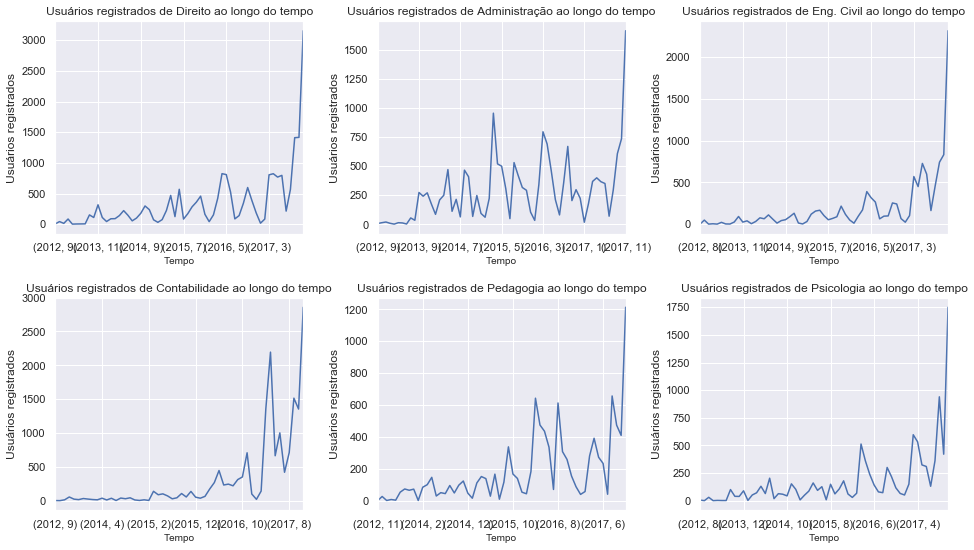

In [261]:
lista_reg = []

lista_reg.append(students_sessions[students_sessions['CourseName'] == "Direito"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Administração"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Engenharia Civil"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Contabilidade / Ciências Contábeis"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Pedagogia"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Psicologia"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Enfermagem"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Medicina"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())

plt.subplots_adjust(wspace = 0.3,hspace=0.3)
plt.subplot(231)
plt.title('Usuários registrados de Direito ao longo do tempo')
plt.ylabel('Usuários registrados', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
lista_reg[0].plot()
plt.subplot(232)
plt.title('Usuários registrados de Administração ao longo do tempo')
plt.ylabel('Usuários registrados', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
lista_reg[1].plot()
plt.subplot(233)
plt.title('Usuários registrados de Eng. Civil ao longo do tempo')
plt.ylabel('Usuários registrados', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
lista_reg[2].plot()
plt.subplot(234)
plt.title('Usuários registrados de Contabilidade ao longo do tempo')
plt.ylabel('Usuários registrados', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
lista_reg[3].plot()
plt.subplot(235)
plt.title('Usuários registrados de Pedagogia ao longo do tempo')
plt.ylabel('Usuários registrados', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
lista_reg[4].plot()
plt.subplot(236)
plt.title('Usuários registrados de Psicologia ao longo do tempo')
plt.ylabel('Usuários registrados', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
lista_reg[5].plot()

6. Outra análise mais simples é das tendências de acesso, a distribuição ao longo do ano é esperada que siga uma sazonalidade de alta próximas aos períodos de prova nas universidades, como podemos ver no mês de Nov/2017, tivemos um pico de acesso no final do mês que provavelmente corresponde a período de provas, e baixa quando começa a terminar por que iniciam as férias para alguns cursos. Para uma análise mais proveitosa seria bom ter um intervalo de tempo maior

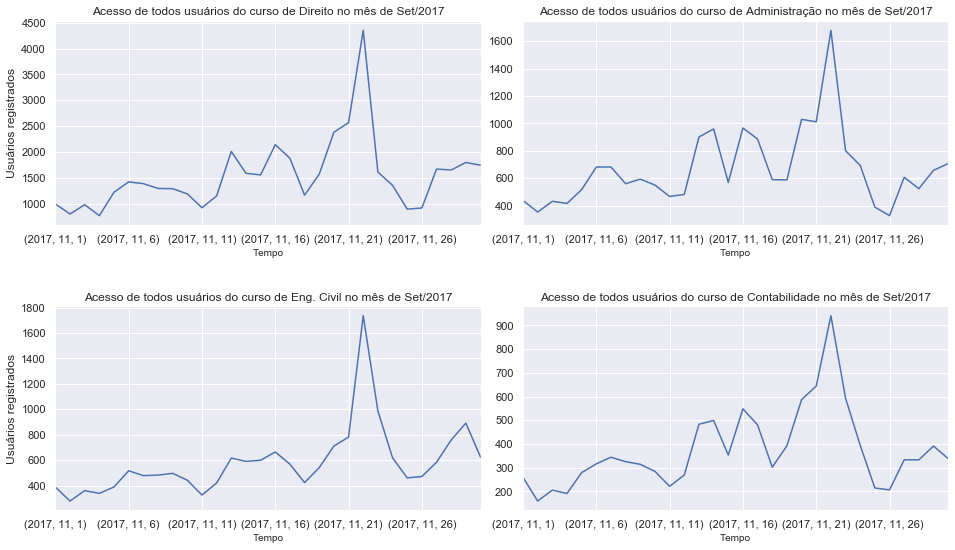

In [262]:
lista_ses = []

lista_ses.append(students_sessions[students_sessions['CourseName'] == "Direito"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Administração"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Engenharia Civil"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Contabilidade / Ciências Contábeis"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Pedagogia"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Psicologia"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Enfermagem"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Medicina"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())

plt.subplots_adjust(wspace = 0.1,hspace=0.4)
plt.subplot(221)
plt.title('Acesso de todos usuários do curso de Direito no mês de Set/2017')
plt.ylabel('Usuários registrados', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
lista_ses[0].plot()
plt.subplot(222)
plt.title('Acesso de todos usuários do curso de Administração no mês de Set/2017')
plt.xlabel('Tempo', fontsize=10)
lista_ses[1].plot()
plt.subplot(223)
plt.title('Acesso de todos usuários do curso de Eng. Civil no mês de Set/2017')
plt.ylabel('Usuários registrados', fontsize=12)
plt.xlabel('Tempo', fontsize=10)
lista_ses[2].plot()
plt.subplot(224)
plt.title('Acesso de todos usuários do curso de Contabilidade no mês de Set/2017')
plt.xlabel('Tempo', fontsize=10)
lista_ses[3].plot()

6. Apesar de não estar completo, esse gráfico evidenciaria a discrepância de fonte de criação das contas dos usuários no PasseiDireto, Facebook seria o pico.

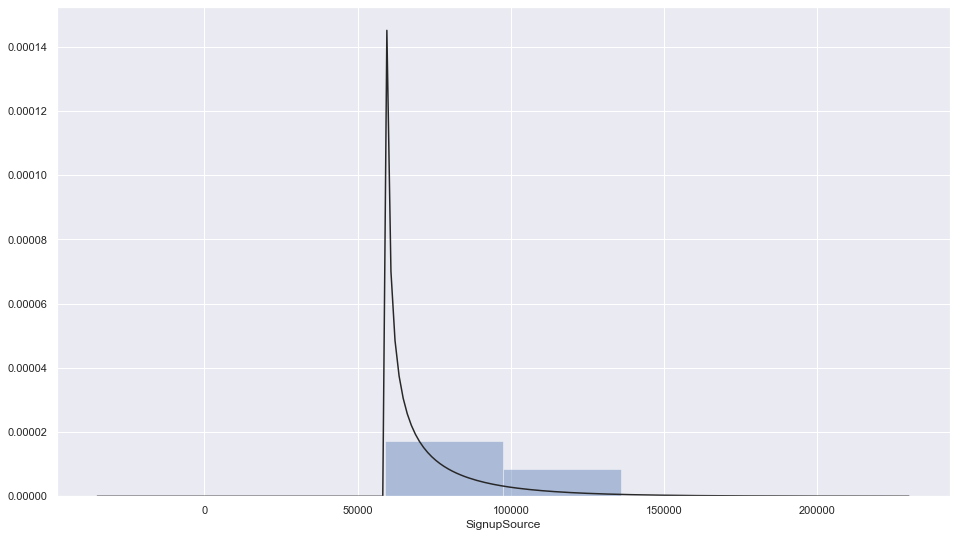

In [264]:
x = students_sessions.SignupSource.value_counts()
sns.distplot(x, kde=False, fit=stats.gamma);

In [265]:
students_sessions.SignupSource.value_counts()

Facebook    136118
Google       88959
Email        58864
Name: SignupSource, dtype: int64

7. Novamente, os estudantes que fazem pedagogia e usam Android, normalmente se registram tanto pelo google quanto pelo facebook, o que difere da maioria dos outros, pois facebook é superior na maior parte dos casos. Por que existe essa diferença das tendências pelo alunos de Pedagogia na plataforma?



In [307]:
students_sessions[(students_sessions['StudentClient_x']=='Android') & (students_sessions['CourseName']=='Pedagogia') ].SignupSource.value_counts()

Google      3399
Facebook    3338
Email        496
Name: SignupSource, dtype: int64

8. Essa visualização ajuda a ver como foi distribuida as inscrições pagas ao longo do mês de Nov/2017, é possível notar uma tendência de pagamento no meio dele, em função de ser um pouco antes da época de provas. Outra análise possível seria futuramente agrupar a distribuição de incrições em relação a distribuição geográfica, poderia comparar com [dados de desigualdade no pais](https://agenciadenoticias.ibge.gov.br/agencia-noticias/2012-agencia-de-noticias/noticias/23299-pobreza-aumenta-e-atinge-54-8-milhoes-de-pessoas-em-2017), e tirar alguma informação relevante que poderia ajudar a pensarmos alguma parceria que seria tanto boa para uma instituição necessitada, quanto para o PasseiDireto.

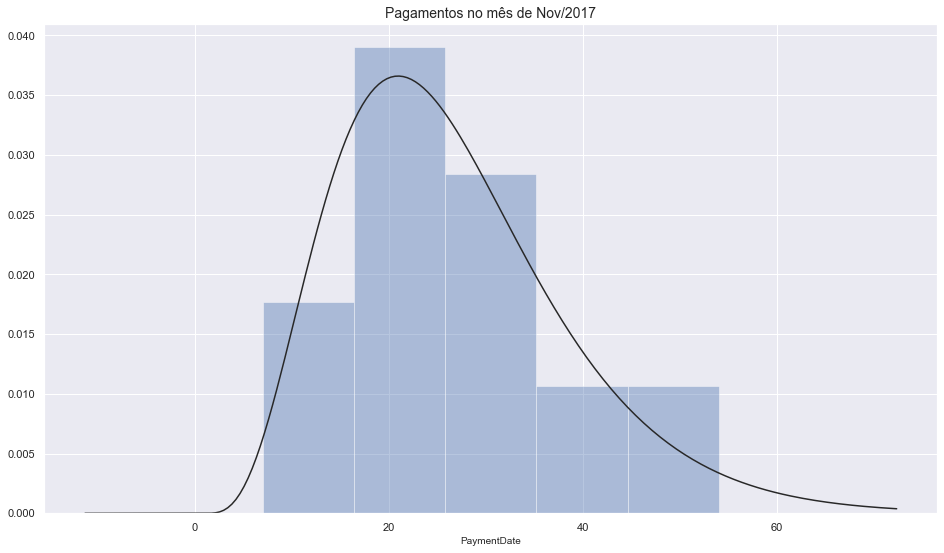

In [267]:
plt.title('Pagamentos no mês de Nov/2017', fontsize=14)
plt.xlabel('Tempo', fontsize=10)
sns.distplot(students_subscriptions.PaymentDate.apply(lambda x: x[:3]).value_counts().sort_index(), kde=False, fit=stats.gamma)


9. Uma visualização de séries temporais que poderia ser interessante com dados maiores, ao longo de um ano inteiro talvez.

In [314]:
df= pd.DataFrame(lista_ses[0]).reset_index().rename(columns = {"index":"SessionStartTime","SessionStartTime":"Volume"});
df["SessionStartTime"] = df["SessionStartTime"].apply(lambda x : str(x[0])+"-"+str(x[1])+"-"+str(x[2]))

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(df.SessionStartTime), y=list(df.Volume)))

fig.update_layout(
    title_text="Séries temporais de acesso no mês de Nov/17 com amplitude do tempo para selecionar"
)

fig.update_layout(
    xaxis=go.layout.XAxis(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1 mês",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6 meses",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="Ao longo de todo o ano",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1 ano",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.show()

10. Por último, fiz a visualização geoespacial dos usuários registrados em um ano inteiro de 2017, futuramente poderia ser interessante fazer a do último mês ou dos últimos 6 meses desde a última data registrada.

In [315]:
state_geo = 'https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/Brasil.json'
state_data = students_sessions[["State","RegisteredDate"]].State.value_counts().reset_index().rename(columns={"index":"ESTADO", "State":"Usuários registrados"})
state_data["Usuários registrados"] = state_data["Usuários registrados"].apply(lambda x: 100*x/state_data["Usuários registrados"].sum())

m = folium.Map(location=[-14, -50], zoom_start=4.4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['ESTADO','Usuários registrados'],
    key_on='feature.properties.ESTADO',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='Taxa de Registrados em um ano'
).add_to(m)

folium.LayerControl().add_to(m)

m

# Se quiser salvar em HTML, só executar essa parte
#folium.LayerControl(collapsed=False).add_to(m)
#time_string = time.asctime().replace(" ", "_")
#time_string = time_string[20:24] +"_"+ time_string[4:7] +"_"+ time_string[8:10]
#m.save(f'banco_bi/visualizacoes/taxa_reg_br_{time_string}.html')

## 6. Sugestões para análises futuras

Ao longo do desafio, tive várias ideias de outros métodos que poderiam ser usados para extrair informações e melhorar a qualidade do banco BI consolidade.

1. Usar [Redes Lógicas de Markov (MLN)](https://cacm.acm.org/magazines/2019/7/237715-unifying-logical-and-statistical-ai-with-markov-logic/abstract) para aprimorar os métodos de extração de conhecimento, e avaliar correlações entre os dados das diferentes tabelas, é um método muito usado para análises que envolvem processamento de linguagem natural, avaliação de correlação entre features de um BD, entre outras possibilidades, vale a pena investigar mais sobre.

2. Fazer um banco de dados separado com variáveis categóricas já transformadas de modo que facilite a implementação de algoritmos de Deep Learning, classificação, predicação como os comentados na parte de pré-processamento de dados;

3. Encontrar uma forma mais genérica de solucionar o problema de imputação de dados faltantes, talvez usando até as Redes Lógicas de Markov;

4. Implementar no luigi o data pipeline, e envolver num container do docker-luigi;

5. Comprimir mais os banco de dados consolidados no final com base numa análise de features relevantes mais precisa, usando algoritmos de clusterização.